# 03 - Modeling (OLS Regression) & Results
In this notebook, we build a multiple linear regression model to understand how different apartment characteristics — especially construction age (Bauperiode) — influence CHF per m².

We will:

1. Load the cleaned dataset from SQLite
2. Prepare Data for Regression
3. Fit an OLS regression
4. Diagnostics & Model Quality Check
5. Interpret results

## 0. Setup

In [12]:
import pandas as pd
import sqlite3
import statsmodels.api as sm


## 1. Load Cleaned Data from SQLite


In [13]:

conn = sqlite3.connect("../Data/apartment_database.db")
df = pd.read_sql("SELECT * FROM rental_listings_clean", conn)
conn.close()

df.head()



,id,area_m2,rooms,rent_chf,year_built,address,canton,bauperiode,chf_per_m2,m2_per_chf
0,1,134,5.5,2530,1984,"Kesslernmattstr. 14, 8965 Berikon",Zurich,Zwischen 1981 und 1990 erbaut,18.880597,0.052964
1,2,98,3.5,2255,1989,"Im Spitzler 21, 8902 Urdorf",Zurich,Zwischen 1981 und 1990 erbaut,23.010204,0.043459
2,3,68,3.5,1945,1973,"Ferdinand Hodler-Str. 14, 8049 Zürich",Zurich,Zwischen 1971 und 1980 erbaut,28.602941,0.034961
3,4,134,5.5,5590,1906,"Weinbergstrasse 72, 8006 Zürich",Zurich,Vor 1919 erbaut,41.716418,0.023971
4,5,94,4.5,2360,1971,"Bahnhofstr. 73, 8957 Spreitenbach",Zurich,Zwischen 1971 und 1980 erbaut,25.106383,0.039831


## 2. Prepare Data for Regression 
We want to model how apartment characteristics affect CHF per m².

Target variable (Y): chf_per_m2

Predictors (X):
- area_m2
- rooms
- year_built
- bauperiode (categorical)
- canton (categorical)

We manually choose baselines: 
- Canton baseline = Zürich
- Bauperiode baseline = "Zwischen 2021 und 2024 erbaut"

## 2.1 Create Dummy Variables 


In [21]:
predictors = ['area_m2', 'rooms', 'year_built', 'bauperiode', 'canton']

# Create full dummy matrix (no automatic baseline)
X = pd.get_dummies(df[predictors], drop_first=False)

# Drop manual baselines
X = X.drop(columns=[
    'canton_Zurich',                                # canton baseline
    'bauperiode_Zwischen 2021 und 2024 erbaut'      # bauperiode baseline
], errors='ignore')

# Convert everything to float so Statsmodels accepts it
X = X.apply(pd.to_numeric, errors='coerce').astype(float)

# Target variable
y = pd.to_numeric(df['chf_per_m2'], errors='coerce').astype(float)

X.head()


,area_m2,rooms,year_built,bauperiode_Vor 1919 erbaut,bauperiode_Zwischen 1919 und 1945 erbaut,bauperiode_Zwischen 1946 und 1960 erbaut,bauperiode_Zwischen 1961 und 1970 erbaut,bauperiode_Zwischen 1971 und 1980 erbaut,bauperiode_Zwischen 1981 und 1990 erbaut,bauperiode_Zwischen 1991 und 2000 erbaut,bauperiode_Zwischen 2001 und 2005 erbaut,bauperiode_Zwischen 2006 und 2010 erbaut,bauperiode_Zwischen 2011 und 2015 erbaut,bauperiode_Zwischen 2016 und 2020 erbaut,canton_Bern,canton_Luzern
0,134.0,5.5,1984.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,98.0,3.5,1989.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,68.0,3.5,1973.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,134.0,5.5,1906.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,94.0,4.5,1971.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Fit Multiple Linear Regression (OLS)
We use Statsmodels OLS because it provides:
- regression coefficients
- p-values
- confidence intervals
- R² and adjusted R²

In [22]:
# Add intercept
X_const = sm.add_constant(X)

# Fit OLS model
model = sm.OLS(y, X_const).fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             chf_per_m2   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     6.514
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           6.93e-10
Time:                        14:27:19   Log-Likelihood:                -399.85
No. Observations:                 120   AIC:                             833.7
Df Residuals:                     103   BIC:                             881.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                      185.2442    502.799      0.368      0.713    -811.940    1182.428
area_m2                                     -0.0788      0.039     -2.026      0.045      -0.156      -0.002
rooms                                       -0.9155      1.187     -0.771      0.442      -3.270       1.439
year_built                                  -0.0673      0.249     -0.271      0.787      -0.560       0.426
bauperiode_Vor 1919 erbaut                  -5.8802     30.671     -0.192      0.848     -66.708      54.948
bauperiode_Zwischen 1919 und 1945 erbaut    -3.0256     21.052     -0.144      0.886     -44.777      38.726
bauperiode_Zwischen 1946 und 1960 erbaut    -8.4071     16.793     -0.501      0.618     -41.712      24.898
bauperiode_Zwischen 1961 und 1970 erbaut   -11.2767     14.755     -0.764      0.446     -40.539      17.985
bauperiode_Zwischen 1971 und 1980 erbaut   -13.4170     12.717     -1.055      0.294     -38.638      11.804
bauperiode_Zwischen 1981 und 1990 erbaut   -13.3295     10.475     -1.272      0.206     -34.105       7.446
bauperiode_Zwischen 1991 und 2000 erbaut   -10.1349      7.942     -1.276      0.205     -25.885       5.616
bauperiode_Zwischen 2001 und 2005 erbaut    -8.8972      6.630     -1.342      0.183     -22.047       4.252
bauperiode_Zwischen 2006 und 2010 erbaut    -7.3812      4.801     -1.537      0.127     -16.903       2.141
bauperiode_Zwischen 2011 und 2015 erbaut    -3.3114      3.720     -0.890      0.375     -10.689       4.066
bauperiode_Zwischen 2016 und 2020 erbaut    -3.9019      3.639     -1.072      0.286     -11.118       3.315
canton_Bern                                -11.1753      1.793     -6.234      0.000     -14.731      -7.620
canton_Luzern                               -3.4004      1.752     -1.941      0.055      -6.876       0.075
==============================================================================
Omnibus:                       47.668   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.167
Skew:                           1.504   Prob(JB):                     3.29e-29
Kurtosis:                       7.146   Cond. No.                     1.51e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 4. Diagnostics & Model Quality 
## 4.1 Check multicollinearity
Statsmodels already reports this under Cond. No.
Values > 1000 may indicate multicollinearity.

➤ What is multicollinearity?

When two predictors are highly correlated (e.g., year_built and bauperiode), the model cannot separate their effects.
→ Coefficients become unstable
→ Standard errors explode
→ p-values become meaningless

➤ Why check it?

Statsmodels prints the Cond. No. (condition number) at the bottom of the regression summary.

Below 100 → good

100–1000 → watch out

Above 1000 → multicollinearity likely

Above 10,000 → your coefficients cannot be trusted

So Section 4.1 tells you whether your dummy variables broke the regression.

## 4.2 Residual analysis 
➤ What are residuals?

Residuals = the difference between actual values and predicted values.

A good regression model has residuals that:

are centered around 0

are roughly symmetric

have no clear pattern

➤ Why plot them?

If residuals look weird, your model might have:

omitted important variables

non-linear relationships

heteroskedasticity

outliers

non-normal error distribution

These issues reduce the reliability of your:

standard errors

p-values

confidence intervals

➤ The histogram/kde plot visually checks:

Are residuals roughly normal?

Are there extreme outliers?

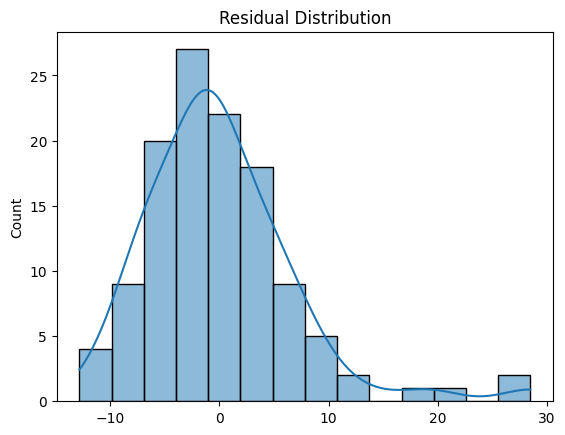

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = model.resid

sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()
